In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Loading Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [20]:
df = pd.read_csv("/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A1/Dataset/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [21]:
# Count zeros for each column
zero_counts = (df == 0).sum()

print("Count of Zero Values for each Variable")
print(zero_counts)

Count of Zero Values for each Variable
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


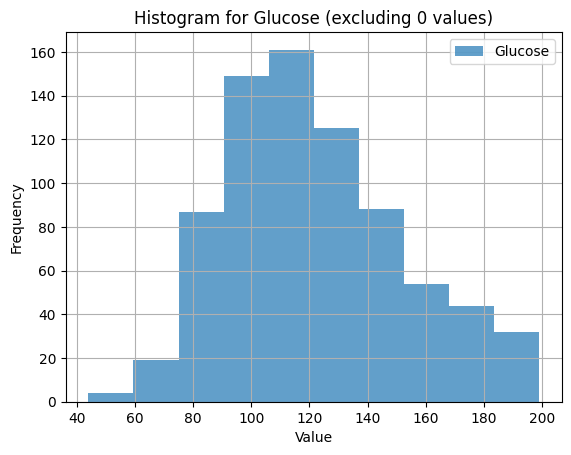

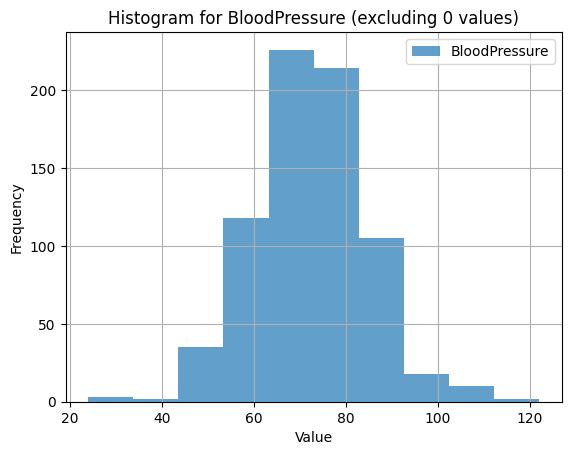

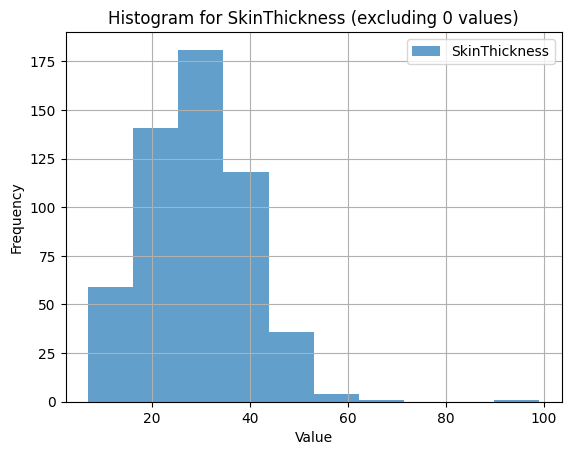

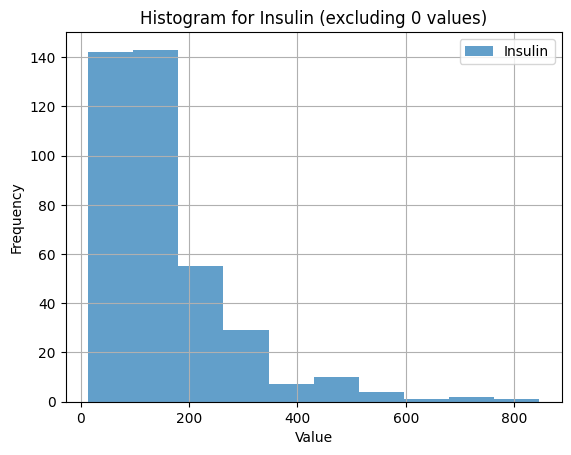

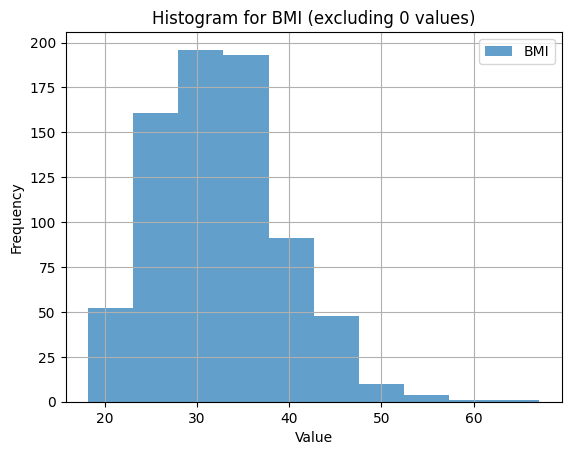

In [7]:
# Plot histograms without 0 values for each column

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in cols:
    df[df[col] != 0][col].hist(alpha=0.7, label=col)
    plt.legend()
    plt.title(f"Histogram for {col} (excluding 0 values)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

In [8]:
# Replacing 0 values with median

for column in cols:
    median_value = df[column].median()
    df[column] = df[column].replace(0, median_value)

print(df)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35     30.5  33.6   
1              1       85             66             29     30.5  26.6   
2              8      183             64             23     30.5  23.3   
3              1       89             66             23     94.0  28.1   
4              0      137             40             35    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48    180.0  32.9   
764            2      122             70             27     30.5  36.8   
765            5      121             72             23    112.0  26.2   
766            1      126             60             23     30.5  30.1   
767            1       93             70             31     30.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [9]:
# Count zeros for each column
zero_counts = (df == 0).sum()

print(zero_counts)

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [10]:
# Splitting data

col = ["Pregnancies","Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

X = df[col].values
y = df['Outcome'].values

# Using Standard Scaling
standard_scaler = StandardScaler()
X_standard = pd.DataFrame(standard_scaler.fit_transform(X), columns=col)
X_standard = X_standard[col].values

X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.2, random_state=21)


In [11]:
X_train

array([[ 0.93691372,  1.29341677,  1.12611029, ..., -0.29849289,
        -0.92680285,  1.17073215],
       [-0.84488505,  0.20854933,  0.79522451, ..., -0.72056346,
        -1.07780879, -0.95646168],
       [ 0.04601433,  0.34004841,  1.12611029, ..., -0.64779267,
        -0.15969271,  2.5321362 ],
       ...,
       [-0.25095213, -1.33656491,  1.12611029, ..., -0.72056346,
        -0.50096612, -0.95646168],
       [ 0.93691372, -0.61331995, -0.5283186 , ...,  0.96771883,
        -0.38620161, -0.19067191],
       [ 0.3429808 ,  1.32629155,  2.61509629, ...,  0.76396062,
        -0.96908451,  1.59617091]])

## Single Layer Perceptron

### Base Model

In [13]:
# Building the Perceptron

class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

input_dim = X_train.shape[1]
model = Perceptron(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0) # indicate gradient descent

In [14]:
# Training model

num_epochs = 1000

for epoch in range(num_epochs):
    inputs = torch.tensor(X_train, dtype=torch.float32)
    labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.6404
Epoch [200/1000], Loss: 0.6312
Epoch [300/1000], Loss: 0.6227
Epoch [400/1000], Loss: 0.6148
Epoch [500/1000], Loss: 0.6075
Epoch [600/1000], Loss: 0.6007
Epoch [700/1000], Loss: 0.5943
Epoch [800/1000], Loss: 0.5884
Epoch [900/1000], Loss: 0.5829
Epoch [1000/1000], Loss: 0.5777


In [15]:
# Evaluate model

with torch.no_grad():
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    test_outputs = model(test_inputs)
    predicted = (test_outputs > 0.5).float()
    accuracy = (predicted == test_labels).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

Accuracy: 0.6818


### Fine-tuning

In [ ]:
# Optimization Algorithm: SGD

def objective(trial):
    # Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    model = Perceptron(input_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 08:23:33,929] A new study created in memory with name: no-name-05df29fd-c6bf-400b-989a-972e5532467c
[I 2023-09-28 08:23:34,362] Trial 0 finished with value: -0.7402597665786743 and parameters: {'lr': 0.007915419894034187, 'weight_decay': 0.003369953363408709}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 08:23:34,763] Trial 1 finished with value: -0.4935064911842346 and parameters: {'lr': 1.9971275285878168e-05, 'weight_decay': 0.005489432258204099}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 08:23:35,187] Trial 2 finished with value: -0.5779221057891846 and parameters: {'lr': 4.704805295196537e-05, 'weight_decay': 8.652197705667825e-05}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 08:23:35,597] Trial 3 finished with value: -0.350649356842041 and parameters: {'lr': 1.806184801357149e-05, 'weight_decay': 0.0005040146448137032}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 08:23:36,024] Trial 4 finis

Best trial:
 Value:  0.7532467246055603
 Params: 
    lr: 0.007679283772466984
    weight_decay: 0.002783770830843479


In [ ]:
# Optimization Algorithm: Adagrad

def objective(trial):
    # Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    model = Perceptron(input_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 08:56:28,348] A new study created in memory with name: no-name-5fdeb3e9-2777-4218-8ed3-15079a0a6cc5
[I 2023-09-28 08:56:29,038] Trial 0 finished with value: -0.7337662577629089 and parameters: {'lr': 0.011841859791825912, 'weight_decay': 0.0002001034246916864}. Best is trial 0 with value: -0.7337662577629089.
[I 2023-09-28 08:56:29,769] Trial 1 finished with value: -0.40909090638160706 and parameters: {'lr': 8.299438127451761e-05, 'weight_decay': 7.344903591401126e-05}. Best is trial 0 with value: -0.7337662577629089.
[I 2023-09-28 08:56:30,474] Trial 2 finished with value: -0.5389610528945923 and parameters: {'lr': 0.0007417451959468823, 'weight_decay': 0.00019905442041981975}. Best is trial 0 with value: -0.7337662577629089.
[I 2023-09-28 08:56:31,309] Trial 3 finished with value: -0.4025973975658417 and parameters: {'lr': 1.700483484086849e-05, 'weight_decay': 0.017220405147970432}. Best is trial 0 with value: -0.7337662577629089.
[I 2023-09-28 08:56:32,114] Trial 4 fi

Best trial:
 Value:  0.7467532753944397
 Params: 
    lr: 0.028509210383924677
    weight_decay: 0.006073339608236784


In [ ]:
# Optimization Algorithm: RMSprop

def objective(trial):
    # Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    model = Perceptron(input_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 08:24:31,494] A new study created in memory with name: no-name-9b0693a7-a652-42d2-921c-7558ab4f241c
[I 2023-09-28 08:24:31,999] Trial 0 finished with value: -0.7337662577629089 and parameters: {'lr': 0.000224783055669153, 'weight_decay': 0.01687759494614641}. Best is trial 0 with value: -0.7337662577629089.
[I 2023-09-28 08:24:32,473] Trial 1 finished with value: -0.7272727489471436 and parameters: {'lr': 0.0002583810640008971, 'weight_decay': 6.99252936713132e-05}. Best is trial 0 with value: -0.7337662577629089.
[I 2023-09-28 08:24:32,961] Trial 2 finished with value: -0.7402597665786743 and parameters: {'lr': 0.007010969295424189, 'weight_decay': 0.0015641891563559383}. Best is trial 2 with value: -0.7402597665786743.
[I 2023-09-28 08:24:33,522] Trial 3 finished with value: -0.6753246784210205 and parameters: {'lr': 0.00010289789752109724, 'weight_decay': 0.002963620573331752}. Best is trial 2 with value: -0.7402597665786743.
[I 2023-09-28 08:24:34,123] Trial 4 finishe

Best trial:
 Value:  0.7532467246055603
 Params: 
    lr: 0.08462289030931756
    weight_decay: 0.010124094763292625


In [ ]:
# Optimization Algorithm: Adam

def objective(trial):
    # Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    model = Perceptron(input_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 07:59:35,003] A new study created in memory with name: no-name-755a487e-bcac-4b5b-bfc9-43105e019eed
[I 2023-09-28 07:59:35,643] Trial 0 finished with value: -0.6688311696052551 and parameters: {'lr': 0.00034236199750338914, 'weight_decay': 0.0013345926694912844}. Best is trial 0 with value: -0.6688311696052551.
[I 2023-09-28 07:59:36,352] Trial 1 finished with value: -0.7402597665786743 and parameters: {'lr': 0.002865915992711153, 'weight_decay': 1.1868492948157178e-05}. Best is trial 1 with value: -0.7402597665786743.
[I 2023-09-28 07:59:37,376] Trial 2 finished with value: -0.7207792401313782 and parameters: {'lr': 0.0004751622849513036, 'weight_decay': 2.1261385381795776e-05}. Best is trial 1 with value: -0.7402597665786743.
[I 2023-09-28 07:59:38,635] Trial 3 finished with value: -0.7402597665786743 and parameters: {'lr': 0.002126611808685346, 'weight_decay': 9.198837959667628e-05}. Best is trial 1 with value: -0.7402597665786743.
[I 2023-09-28 07:59:40,802] Trial 4 f

Best trial:
 Value:  0.7467532753944397
 Params: 
    lr: 0.06179841361252771
    weight_decay: 0.01602194745444105


## Multi-Layer Perceptron (MLP)

### Base Model

In [16]:
# Building the MLP

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return self.sigmoid(x)

input_dim = X_train.shape[1]
hidden_dims = [10,5,2]
model = MLP(input_dim, hidden_dims)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.001, momentum=0)

In [17]:
# Training the model

num_epochs = 1000
for epoch in range(num_epochs):
    inputs = torch.tensor(X_train, dtype=torch.float32)
    labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.6737
Epoch [200/1000], Loss: 0.6723
Epoch [300/1000], Loss: 0.6709
Epoch [400/1000], Loss: 0.6696
Epoch [500/1000], Loss: 0.6683
Epoch [600/1000], Loss: 0.6671
Epoch [700/1000], Loss: 0.6660
Epoch [800/1000], Loss: 0.6649
Epoch [900/1000], Loss: 0.6639
Epoch [1000/1000], Loss: 0.6629


In [18]:
# Evaluation
with torch.no_grad():
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    test_outputs = model(test_inputs)
    predicted = (test_outputs > 0.5).float()
    accuracy = (predicted == test_labels).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')


Accuracy: 0.6104


### Fine-tuning

In [ ]:
# Optimization Algorithm: SGD

def objective(trial):
    # 1. Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    # Number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_dims = []
    for i in range(n_layers):
        # Number of neurons in each hidden layer
        n_units = trial.suggest_int(f"n_units_layer_{i}", 1, 128)
        hidden_dims.append(n_units)

    # Activation function
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    if activation_name == "ReLU":
        activation = nn.ReLU()
    else:
        activation = nn.LeakyReLU()

    model = MLP(input_dim, hidden_dims)
    model.activation = activation

    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

# Running the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

# Displaying results
print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 11:21:39,848] A new study created in memory with name: no-name-a0080b70-3ac3-45fd-854a-eeb58757b269
[I 2023-09-28 11:21:41,439] Trial 0 finished with value: -0.3896103799343109 and parameters: {'lr': 0.0001410374078269502, 'weight_decay': 0.037572124291556416, 'n_layers': 4, 'n_units_layer_0': 104, 'n_units_layer_1': 53, 'n_units_layer_2': 14, 'n_units_layer_3': 6, 'activation': 'LeakyReLU'}. Best is trial 0 with value: -0.3896103799343109.
[I 2023-09-28 11:21:42,105] Trial 1 finished with value: -0.4740259647369385 and parameters: {'lr': 0.00010650095055534255, 'weight_decay': 2.4160207669633706e-05, 'n_layers': 1, 'n_units_layer_0': 51, 'activation': 'LeakyReLU'}. Best is trial 1 with value: -0.4740259647369385.
[I 2023-09-28 11:21:43,467] Trial 2 finished with value: -0.6103895902633667 and parameters: {'lr': 0.007540116004765522, 'weight_decay': 0.05020695310699353, 'n_layers': 4, 'n_units_layer_0': 42, 'n_units_layer_1': 17, 'n_units_layer_2': 33, 'n_units_layer_3': 

Best trial:
 Value:  0.7662337422370911
 Params: 
    lr: 0.0944593526988057
    weight_decay: 0.006053251016952093
    n_layers: 2
    n_units_layer_0: 79
    n_units_layer_1: 89
    activation: ReLU


In [ ]:
# Optimization Algorithm: Adagrad

def objective(trial):
    # 1. Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    # Number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_dims = []
    for i in range(n_layers):
        # Number of neurons in each hidden layer
        n_units = trial.suggest_int(f"n_units_layer_{i}", 1, 128)
        hidden_dims.append(n_units)

    # Activation function
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    if activation_name == "ReLU":
        activation = nn.ReLU()
    else:
        activation = nn.LeakyReLU()

    model = MLP(input_dim, hidden_dims)
    model.activation = activation

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

# Running the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

# Displaying results
print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 11:27:54,265] A new study created in memory with name: no-name-cdd172a7-dc38-46d2-ad43-821239bd5de0
[I 2023-09-28 11:28:51,298] Trial 0 finished with value: -0.7142857313156128 and parameters: {'lr': 0.04468507930485382, 'weight_decay': 0.0003816113271277397, 'n_layers': 5, 'n_units_layer_0': 9, 'n_units_layer_1': 90, 'n_units_layer_2': 122, 'n_units_layer_3': 93, 'n_units_layer_4': 88, 'activation': 'ReLU'}. Best is trial 0 with value: -0.7142857313156128.
[I 2023-09-28 11:28:53,011] Trial 1 finished with value: -0.6103895902633667 and parameters: {'lr': 6.924760301412085e-05, 'weight_decay': 2.523658930737175e-05, 'n_layers': 2, 'n_units_layer_0': 25, 'n_units_layer_1': 66, 'activation': 'LeakyReLU'}. Best is trial 0 with value: -0.7142857313156128.
[I 2023-09-28 11:28:56,957] Trial 2 finished with value: -0.701298713684082 and parameters: {'lr': 0.09227127514801567, 'weight_decay': 5.088558674241196e-05, 'n_layers': 5, 'n_units_layer_0': 44, 'n_units_layer_1': 74, 'n_u

Best trial:
 Value:  0.7792207598686218
 Params: 
    lr: 0.006928404166728484
    weight_decay: 3.502305558863795e-05
    n_layers: 2
    n_units_layer_0: 104
    n_units_layer_1: 5
    activation: LeakyReLU


In [ ]:
# Optimization Algorithm: RMSprop

def objective(trial):
    # 1. Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    # Number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_dims = []
    for i in range(n_layers):
        # Number of neurons in each hidden layer
        n_units = trial.suggest_int(f"n_units_layer_{i}", 1, 128)
        hidden_dims.append(n_units)

    # Activation function
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    if activation_name == "ReLU":
        activation = nn.ReLU()
    else:
        activation = nn.LeakyReLU()

    model = MLP(input_dim, hidden_dims)
    model.activation = activation

    criterion = nn.BCELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

# Running the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

# Displaying results
print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-09-28 11:24:30,970] A new study created in memory with name: no-name-ab13bd3f-6431-43d1-864a-fc226ad9219d
[I 2023-09-28 11:24:31,813] Trial 0 finished with value: -0.7402597665786743 and parameters: {'lr': 0.00011712129055731747, 'weight_decay': 1.2773722725801407e-05, 'n_layers': 1, 'n_units_layer_0': 47, 'activation': 'ReLU'}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 11:24:36,330] Trial 1 finished with value: -0.6948052048683167 and parameters: {'lr': 0.00026087771112492784, 'weight_decay': 7.80355368123627e-05, 'n_layers': 5, 'n_units_layer_0': 103, 'n_units_layer_1': 70, 'n_units_layer_2': 89, 'n_units_layer_3': 120, 'n_units_layer_4': 107, 'activation': 'LeakyReLU'}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 11:24:38,350] Trial 2 finished with value: -0.4935064911842346 and parameters: {'lr': 2.065380141158778e-05, 'weight_decay': 0.04654828815821259, 'n_layers': 5, 'n_units_layer_0': 23, 'n_units_layer_1': 16, 'n_units_layer_2': 

Best trial:
 Value:  0.7792207598686218
 Params: 
    lr: 0.000289324995209056
    weight_decay: 2.517862185413488e-05
    n_layers: 2
    n_units_layer_0: 19
    n_units_layer_1: 30
    activation: ReLU


In [ ]:
# Optimization Algorithm: Adam

def objective(trial):
    # 1. Define the hyperparameters' search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    # Number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_dims = []
    for i in range(n_layers):
        # Number of neurons in each hidden layer
        n_units = trial.suggest_int(f"n_units_layer_{i}", 1, 128)
        hidden_dims.append(n_units)

    # Activation function
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    if activation_name == "ReLU":
        activation = nn.ReLU()
    else:
        activation = nn.LeakyReLU()

    model = MLP(input_dim, hidden_dims)
    model.activation = activation

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training logic
    num_epochs = 1000
    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation logic
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        predicted = (test_outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()

    return -accuracy.item()  # We return negative accuracy since optuna tries to minimize the objective

# Running the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Number of trials

# Displaying results
print("Best trial:")
trial = study.best_trial
print(" Value: ", -trial.value)  # Print the best accuracy
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-09-28 11:15:38,621] A new study created in memory with name: no-name-0ced1397-fe5a-429b-ac50-d3659625c00d
[I 2023-09-28 11:15:39,679] Trial 0 finished with value: -0.7402597665786743 and parameters: {'lr': 0.0007205747319998956, 'weight_decay': 0.001133746607628858, 'n_layers': 1, 'n_units_layer_0': 75, 'activation': 'ReLU'}. Best is trial 0 with value: -0.7402597665786743.
[I 2023-09-28 11:15:42,439] Trial 1 finished with value: -0.7467532753944397 and parameters: {'lr': 0.0004878988282438355, 'weight_decay': 0.0003802741933711955, 'n_layers': 5, 'n_units_layer_0': 118, 'n_units_layer_1': 39, 'n_units_layer_2': 50, 'n_units_layer_3': 19, 'n_units_layer_4': 81, 'activation': 'ReLU'}. Best is trial 1 with value: -0.7467532753944397.
[I 2023-09-28 11:15:45,200] Trial 2 finished with value: -0.7402597665786743 and parameters: {'lr': 0.09870394783260282, 'weight_decay': 0.021003481009342552, 'n_layers': 3, 'n_units_layer_0': 56, 'n_units_layer_1': 89, 'n_units_layer_2': 109, 'activ

Best trial:
 Value:  0.7792207598686218
 Params: 
    lr: 0.0002568734188358481
    weight_decay: 0.000469012185519357
    n_layers: 4
    n_units_layer_0: 24
    n_units_layer_1: 71
    n_units_layer_2: 14
    n_units_layer_3: 52
    activation: LeakyReLU
